In [114]:
# Data Reading Modules
import pandas as pd
from torchvision.datasets import ImageFolder
from PIL import Image

# Data Visualization Modules
import matplotlib.pyplot as plt

# Data Manipulation Modules
import numpy as np 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# DL Modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

# Other Modules
import time

In [39]:
PATH_TO_IMAGEFOLDERS = './data/ImageData/balanced'

In [16]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Loading + Transformation

In [90]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((32, 32))
                               ]) # Images already normalized

In [91]:
dataset = ImageFolder(root = PATH_TO_IMAGEFOLDERS, transform = transform)

In [92]:
rest_data, test_data = train_test_split(dataset, test_size = 0.1, random_state=97)
train_data, val_data = train_test_split(rest_data, test_size = 0.1, random_state=97)

#### 81% Train data, 9% Val data, 10% Test data

In [93]:
classes = ['Center', 'Donut', 'Edge-loc', 'Edge-ring', 'Loc', 'Near-Full', 'None', 'Random', 'Scratch']

In [119]:
BATCH_SIZE = 16
NUM_EPOCHS = 30

In [95]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### Create Model

In [116]:
class CNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.Conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(in_features=32*6*6, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)
        
    def forward(self, x):
        output = self.Conv1(x)
        output = self.pool(output)
        output = self.Conv2(output)
        output = self.pool(output)
        output = output.view(-1, 32 * 6 * 6) #flatten
        output = F.relu(self.fc1(output))
        output = self.fc2(output)
        
        return output

    
myCNN = CNN(input_channels=3, num_classes = len(classes))

In [117]:
optimizer = optim.SGD(myCNN.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#### Training

In [118]:
def train_model(model, num_epochs, criterion, optimizer, data):
    start_time = time.time()
    n_total_steps = (len(data))
    model.train()
    loss_history = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for batch_id, (images, labels) in enumerate(data):
            
            outputs= model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad() #Gradienten zurücksetzen
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        
            if (batch_id+1) % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, step: {batch_id+1}/{n_total_steps}, loss = {loss.item():.4f}')
                
        avg_epoch_loss = epoch_loss /n_total_steps
        loss_history.append(avg_epoch_loss)
            
            

    end_time = time.time()
    total_time = end_time-start_time
    print(f'Training abgeschlossen in {total_time:.2f} Sekunden')
    
    #Plot für den Loss
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, num_epochs+1))
    plt.title('Loss curve')
    plt.show()

Epoch: 1/30, step: 100/187, loss = 2.2311
Epoch: 2/30, step: 100/187, loss = 2.1570
Epoch: 3/30, step: 100/187, loss = 2.1443
Epoch: 4/30, step: 100/187, loss = 2.1613
Epoch: 5/30, step: 100/187, loss = 2.0525
Epoch: 6/30, step: 100/187, loss = 1.9698
Epoch: 7/30, step: 100/187, loss = 1.9674
Epoch: 8/30, step: 100/187, loss = 1.7338
Epoch: 9/30, step: 100/187, loss = 1.6110
Epoch: 10/30, step: 100/187, loss = 1.7842
Epoch: 11/30, step: 100/187, loss = 1.5666
Epoch: 12/30, step: 100/187, loss = 1.1825
Epoch: 13/30, step: 100/187, loss = 1.3577
Epoch: 14/30, step: 100/187, loss = 1.7094
Epoch: 15/30, step: 100/187, loss = 1.5012
Epoch: 16/30, step: 100/187, loss = 0.9994
Epoch: 17/30, step: 100/187, loss = 1.1707
Epoch: 18/30, step: 100/187, loss = 1.0359
Epoch: 19/30, step: 100/187, loss = 0.7811
Epoch: 20/30, step: 100/187, loss = 0.9843
Epoch: 21/30, step: 100/187, loss = 0.8685
Epoch: 22/30, step: 100/187, loss = 0.8088
Epoch: 23/30, step: 100/187, loss = 0.7025
Epoch: 24/30, step: 

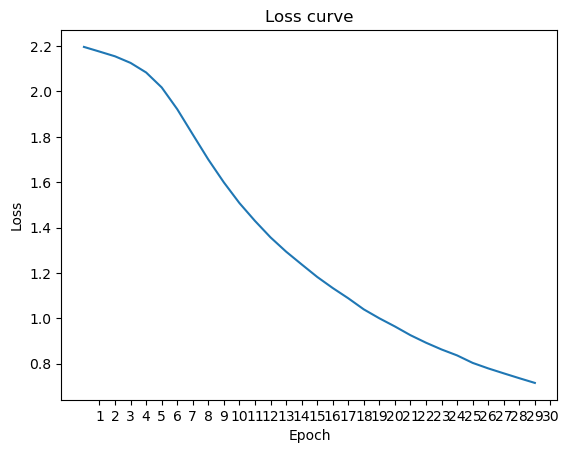

In [120]:
train_model(model=myCNN, num_epochs=NUM_EPOCHS, criterion=criterion, optimizer=optimizer, data=train_loader)

In [134]:
num_correct = 0
num_samples = 0
n_class_correct = 0
n_class_samples = 0
with torch.no_grad():  # Deaktivieren des Gradienten-Tracking, um Speicher zu sparen
    for images, labels in train_loader:
        outputs = myCNN(images)
        _, predicted = torch.max(outputs, 1) #torch.max returns (value, index)
        num_correct += (predicted == labels).sum().item()
        num_samples += labels.size(0)
        
            
    accuracy = num_correct / num_samples
    print(f'Accuracy auf dem Trainingsdatensatz: {100 * accuracy:.2f}%')
    
   

Accuracy auf dem Trainingsdatensatz: 74.23%
